In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

from pingouin import partial_corr
import pingouin as pg
from sklearn.model_selection import RepeatedKFold, cross_val_score
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

import geopandas as gpd
from geopandas.tools import sjoin

In [348]:
dfSCali = pd.read_csv('../../../orig_data/US_S_CA/SoCal_GrainSize_waves_slopes_tide_merged.csv')

In [349]:
# dfSCali = dfSCali[dfSCali['Grain_Size']<1.0] ## too few samples >1.0
dfSCali = dfSCali[dfSCali['Grain_Size']<2] ## too few samples >1.0

In [350]:
len(dfSCali)

1392

In [366]:
df_strat_gs = dfSCali.copy()

num_cats=12
num_samples_per_category = 20

df_strat_gs['category'] = pd.cut(df_strat_gs['Grain_Size'], num_cats)
df_strat_gs = df_strat_gs.groupby(['category']).apply(lambda x: x.sample(num_samples_per_category, replace = True)).reset_index(drop = True)

len(df_strat_gs)

240

In [367]:
df_strat_gs['category']

0      (-0.00194, 0.162]
1      (-0.00194, 0.162]
2      (-0.00194, 0.162]
3      (-0.00194, 0.162]
4      (-0.00194, 0.162]
             ...        
235       (1.781, 1.943]
236       (1.781, 1.943]
237       (1.781, 1.943]
238       (1.781, 1.943]
239       (1.781, 1.943]
Name: category, Length: 240, dtype: category
Categories (12, interval[float64, right]): [(-0.00194, 0.162] < (0.162, 0.324] < (0.324, 0.486] < (0.486, 0.648] ... (1.295, 1.457] < (1.457, 1.619] < (1.619, 1.781] < (1.781, 1.943]]

In [329]:
# df_strat_lat = dfSCali.copy()

# num_cats=5
# num_samples_per_category = 60

# df_strat_lat['category'] = pd.cut(df_strat_lat['Lat'], num_cats)
# df_strat_lat = df_strat_lat.groupby(['category']).apply(lambda x: x.sample(num_samples_per_category, replace = False)).reset_index(drop = True)

# len(df_strat_lat)

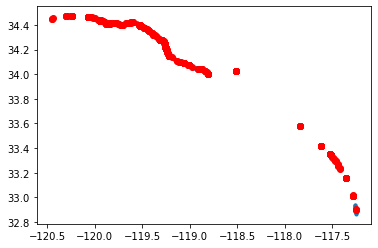

In [330]:
# plt.plot(dfSCali['Lon'], dfSCali['Lat'], '.')
# plt.plot(df_strat_lat['Lon'], df_strat_lat['Lat'], 'ro')

In [331]:
# dfSCali = df_strat_lat.copy()
# len(dfSCali)

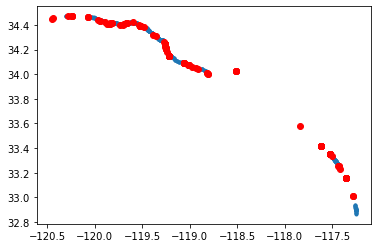

In [368]:
plt.plot(dfSCali['Lon'], dfSCali['Lat'], '.')
plt.plot(df_strat_gs['Lon'], df_strat_gs['Lat'], 'ro')

In [369]:
dfSCali = df_strat_gs.copy()
len(dfSCali)

240

### Beachface sand

In [370]:
dfSCali = dfSCali[dfSCali['Ele']=='BF']
dfSCali = dfSCali.dropna()

In [371]:
dfSCali.keys()

Index(['Unnamed: 0', 'Ele', 'dataset', 'Grain_Size', 'Hs', 'Tp', 'Ta', 'Dp',
       'Da', 'Ea', 'Es', 'geometry', 'Lon', 'Lat', 'Beach face slope',
       'index_right', 'MEAN_SIG_WAVEHEIGHT', 'TIDAL_RANGE', 'ERODIBILITY',
       'CHLOROPHYLL', 'TURBIDITY', 'REGIONAL_SINUOSITY',
       'OUTFLOW_DENSITY_RESCALED', 'category'],
      dtype='object')

In [372]:
dfSCali

,Unnamed: 0,Ele,dataset,Grain_Size,Hs,Tp,Ta,Dp,Da,Ea,...,Beach face slope,index_right,MEAN_SIG_WAVEHEIGHT,TIDAL_RANGE,ERODIBILITY,CHLOROPHYLL,TURBIDITY,REGIONAL_SINUOSITY,OUTFLOW_DENSITY_RESCALED,category
7,454,BF,SC_Beach,0.119207,0.471879,13.503772,6.759757,190.163111,198.507856,0.071827,...,0.125,1586,1.595954,2.443020,Medium,1.387715,0.0586,1.044490,0.000006,"(-0.00194, 0.162]"
20,112,BF,Barnard_Santa_Barbara,0.313100,0.324704,13.261334,8.268525,200.886225,201.017797,0.036279,...,0.035,1500,1.229692,2.465291,Medium,2.450058,0.0570,1.081441,0.000077,"(0.162, 0.324]"
22,876,BF,Yates_Oceanside,0.178145,0.798118,14.240321,8.094112,229.412118,239.928318,0.247379,...,0.055,515,1.009815,2.476446,High,1.051371,0.0648,1.363763,0.000066,"(0.162, 0.324]"
23,234,BF,Barnard_Santa_Barbara,0.306800,0.485931,12.074118,6.882265,216.058124,218.575441,0.072683,...,0.060,1468,1.229692,2.507136,High,1.641315,0.0538,1.083677,0.000109,"(0.162, 0.324]"
24,893,BF,Yates_Oceanside,0.207809,0.838615,14.090832,8.200167,226.579987,237.522363,0.276630,...,0.045,513,1.009815,2.475991,High,1.011539,0.0648,1.363763,0.000066,"(0.162, 0.324]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,106,BF,SC_Beach,1.942912,0.765155,13.720220,7.870910,227.992884,236.904423,0.219924,...,0.065,578,0.825399,2.480865,High,1.018145,0.0696,1.041937,0.000100,"(1.781, 1.943]"
236,106,BF,SC_Beach,1.942912,0.765155,13.720220,7.870910,227.992884,236.904423,0.219924,...,0.065,578,0.825399,2.480865,High,1.018145,0.0696,1.041937,0.000100,"(1.781, 1.943]"
237,106,BF,SC_Beach,1.942912,0.765155,13.720220,7.870910,227.992884,236.904423,0.219924,...,0.065,578,0.825399,2.480865,High,1.018145,0.0696,1.041937,0.000100,"(1.781, 1.943]"
238,106,BF,SC_Beach,1.942912,0.765155,13.720220,7.870910,227.992884,236.904423,0.219924,...,0.065,578,0.825399,2.480865,High,1.018145,0.0696,1.041937,0.000100,"(1.781, 1.943]"


(array([13., 11.,  9., 18.,  2., 20., 20., 15.,  5., 20.]),
 array([0.11920699, 0.30157751, 0.48394802, 0.66631854, 0.84868906,
        1.03105958, 1.2134301 , 1.39580061, 1.57817113, 1.76054165,
        1.94291217]),
 <BarContainer object of 10 artists>)

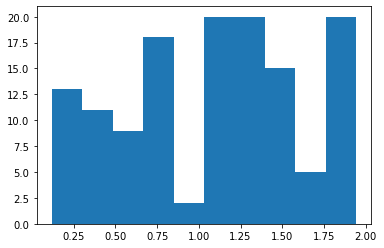

In [373]:
plt.hist(dfSCali['Grain_Size'])

In [374]:
dfSCali.keys()

Index(['Unnamed: 0', 'Ele', 'dataset', 'Grain_Size', 'Hs', 'Tp', 'Ta', 'Dp',
       'Da', 'Ea', 'Es', 'geometry', 'Lon', 'Lat', 'Beach face slope',
       'index_right', 'MEAN_SIG_WAVEHEIGHT', 'TIDAL_RANGE', 'ERODIBILITY',
       'CHLOROPHYLL', 'TURBIDITY', 'REGIONAL_SINUOSITY',
       'OUTFLOW_DENSITY_RESCALED', 'category'],
      dtype='object')

In [375]:
# parameters = {
#     'n_estimators':[100,500,1000], 
#     'max_depth':[3,5,7,9], 
#     "min_samples_split":[3,5,7,9], 
#     "learning_rate": [0.001,0.01,0.1], 
#     "subsample": [0.5,0.75,1.0],
#     "loss": ["squared_error", "huber"]
# }

parameters = {
    'n_estimators':[25,50, 100,200, 500], 
    'max_depth':[3,5,7,9], 
    "min_samples_split":[3,5,7,9], 
    "learning_rate": [0.01,0.05, 0.1], 
    "subsample": [0.25,0.5,0.75,1.0],
    "loss": ["squared_error", "absolute_error", "huber"]
}

In [376]:
rand = np.random.randn(len(dfSCali))
np.save('../model_out/SCali_randBF.npy', rand, allow_pickle=True)

In [377]:
# yscaler = preprocessing.StandardScaler().fit(dfSCali['Grain_Size'].values.reshape(-1, 1))
# y = yscaler.transform(dfSCali['Grain_Size'].values.reshape(-1, 1))

### model 1

In [378]:
Smean = []
Sstd = []

test_size = 0.5

standardize = False

In [379]:
feature_names1 = ['β (radians)', 'Random\n (non-dim.)']
X = np.stack((dfSCali['Beach face slope'], rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X.T,dfSCali['Grain_Size'], test_size=test_size, random_state=43  ##
)

# X_train1, X_test1, y_train1, y_test1 = train_test_split(
#     X.T,y.ravel(), test_size=test_size, random_state=2022  ##dfEAus['d50']
# )


# # unscale y - we balanced it to sample equally among grain size bins
# y_test1 = yscaler.inverse_transform(y_test1.reshape(-1, 1)).squeeze()
# y_train1 = yscaler.inverse_transform(y_train1.reshape(-1, 1)).squeeze()

print(y_test1.max())
print(y_train1.max())

# model1 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model1 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)

model1.fit(X_train1, y_train1)

mse1 = mean_squared_error(y_test1, model1.predict(X_test1))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse1))

1.942912168
1.942912168
Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
The mean squared error (MSE) on test set: 0.3753


In [380]:
model1.best_params_

{'learning_rate': 0.05,
 'loss': 'absolute_error',
 'max_depth': 5,
 'min_samples_split': 5,
 'n_estimators': 25,
 'subsample': 0.25}

In [381]:
model1out = {}
model1out['feature_names'] = feature_names1
model1out['Xtest'] = X_test1
model1out['Xtrain'] = X_train1
model1out['ytest'] = y_test1
model1out['ytrain'] = y_train1
model1out['model'] = model1
model1out['mse'] = mse1
model1out['best_params'] = model1.best_params_

In [382]:
# model1 = model1.best_estimator_

In [383]:
model1 = model1.best_estimator_

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model1, X_test1, y_test1, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.545 (0.100)


### model 2

In [384]:
feature_names2 = [r'MSTR (m)', 'Random\n (non-dim.)']
X = np.stack((dfSCali['TIDAL_RANGE'], rand))

X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X.T, dfSCali['Grain_Size'], test_size=test_size, random_state=43
)

# model2 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model2 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model2.fit(X_train2, y_train2)

mse2 = mean_squared_error(y_test2, model2.predict(X_test2))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse2))

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
The mean squared error (MSE) on test set: 0.2179


In [385]:
print(model2.best_params_)
model2out = {}
model2out['feature_names'] = feature_names2
model2out['Xtest'] = X_test2
model2out['Xtrain'] = X_train2
model2out['ytest'] = y_test2
model2out['ytrain'] = y_train2
model2out['model'] = model2
model2out['mse'] = mse2
model2out['best_params'] = model2.best_params_

{'learning_rate': 0.01, 'loss': 'squared_error', 'max_depth': 3, 'min_samples_split': 7, 'n_estimators': 100, 'subsample': 1.0}


In [386]:
model2 = model2.best_estimator_

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model2, X_test2, y_test2, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.428 (0.094)


### model 3

In [387]:
feature_names3 = ['β (radians)','MSTR (m)', 'Random\n (non-dim.)']
X = np.stack((dfSCali['Beach face slope'], dfSCali['TIDAL_RANGE'], rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train3, X_test3, y_train3, y_test3 = train_test_split(
    X.T, dfSCali['Grain_Size'], test_size=test_size, random_state=43
)

# model3 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model3 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model3.fit(X_train3, y_train3)

mse3 = mean_squared_error(y_test3, model3.predict(X_test3))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse3))

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
The mean squared error (MSE) on test set: 0.2203


In [388]:
print(model3.best_params_)
model3out = {}
model3out['feature_names'] = feature_names3
model3out['Xtest'] = X_test3
model3out['Xtrain'] = X_train3
model3out['ytest'] = y_test3
model3out['ytrain'] = y_train3
model3out['model'] = model3
model3out['mse'] = mse3
model3out['best_params'] = model3.best_params_

{'learning_rate': 0.01, 'loss': 'squared_error', 'max_depth': 3, 'min_samples_split': 3, 'n_estimators': 100, 'subsample': 1.0}


In [389]:
model3 = model3.best_estimator_

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model3, X_test3, y_test3, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.426 (0.092)


### model 4

In [390]:
feature_names4 = ['β (radians)','MSTR (m)',r'$T_p$ (s)', 'Random\n (non-dim.)']
X = np.stack((dfSCali['Beach face slope'], dfSCali['TIDAL_RANGE'], dfSCali['Tp'], rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train4, X_test4, y_train4, y_test4 = train_test_split(
    X.T, dfSCali['Grain_Size'], test_size=test_size, random_state=43
)

# model4 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model4 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)

model4.fit(X_train4, y_train4)

mse4 = mean_squared_error(y_test4, model4.predict(X_test4))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse4))

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
The mean squared error (MSE) on test set: 0.1979


In [391]:
print(model4.best_params_)

model4out = {}
model4out['feature_names'] = feature_names4
model4out['Xtest'] = X_test4
model4out['Xtrain'] = X_train4
model4out['ytest'] = y_test4
model4out['ytrain'] = y_train4
model4out['model'] = model4
model4out['mse'] = mse4
model4out['best_params'] = model4.best_params_

{'learning_rate': 0.05, 'loss': 'squared_error', 'max_depth': 3, 'min_samples_split': 3, 'n_estimators': 25, 'subsample': 1.0}


In [392]:
model4 = model4.best_estimator_

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model4, X_test4, y_test4, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.415 (0.089)


### model 5

In [393]:
feature_names5 = ['β (radians)','MSTR (m)',r'$H_s$ (m)', 'Random\n (non-dim.)']
X = np.stack((dfSCali['Beach face slope'], dfSCali['TIDAL_RANGE'], dfSCali['Hs'], rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train5, X_test5, y_train5, y_test5 = train_test_split(
    X.T, dfSCali['Grain_Size'], test_size=test_size, random_state=43
)

# model5 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model5 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model5.fit(X_train5, y_train5)

mse5 = mean_squared_error(y_test5, model5.predict(X_test5))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse5))

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
The mean squared error (MSE) on test set: 0.2223


In [394]:
# redo above

In [395]:
print(model5.best_params_)
model5out = {}
model5out['feature_names'] = feature_names5
model5out['Xtest'] = X_test5
model5out['Xtrain'] = X_train5
model5out['ytest'] = y_test5
model5out['ytrain'] = y_train5
model5out['model'] = model5
model5out['mse'] = mse5
model5out['best_params'] = model5.best_params_

{'learning_rate': 0.05, 'loss': 'absolute_error', 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 50, 'subsample': 0.75}


In [396]:
model5 = model5.best_estimator_

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model5, X_test5, y_test5, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.431 (0.095)


### model 6

In [397]:
feature_names6 = ['β (radians)','MSTR (m)',r'$\theta$ (deg.)', 'Random\n (non-dim.)']
X = np.stack((dfSCali['Beach face slope'], dfSCali['TIDAL_RANGE'], dfSCali['Dp'], rand))

X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train6, X_test6, y_train6, y_test6 = train_test_split(
    X.T, dfSCali['Grain_Size'], test_size=test_size, random_state=43
)

# model6 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model6 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model6.fit(X_train6, y_train6)

mse6 = mean_squared_error(y_test6,model6.predict(X_test6))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse6))

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
The mean squared error (MSE) on test set: 0.2051


In [398]:
print(model6.best_params_)

model6out = {}
model6out['feature_names'] = feature_names6
model6out['Xtest'] = X_test6
model6out['Xtrain'] = X_train6
model6out['ytest'] = y_test6
model6out['ytrain'] = y_train6
model6out['model'] = model6
model6out['mse'] = mse6
model6out['best_params'] = model6.best_params_

{'learning_rate': 0.05, 'loss': 'squared_error', 'max_depth': 3, 'min_samples_split': 3, 'n_estimators': 25, 'subsample': 1.0}


In [399]:
model6 = model6.best_estimator_

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model6, X_test6, y_test6, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.406 (0.091)


### model 7

In [400]:
feature_names7 = ['MSTR (m)',r'$T_p$ (s)',r'$H_s$ (m)', 'Random\n (non-dim.)']
# X = np.stack((dfEAus['mstr'], dfEAus['tp'], dfEAus['hs_mean'],  rand))
X = np.stack((dfSCali['TIDAL_RANGE'], dfSCali['Tp'], dfSCali['Hs'], rand))

X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train7, X_test7, y_train7, y_test7 = train_test_split(
    X.T, dfSCali['Grain_Size'], test_size=test_size, random_state=43
)

# model7 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model7 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model7.fit(X_train7, y_train7)

mse7 = mean_squared_error(y_test7,model7.predict(X_test7))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse7))

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
The mean squared error (MSE) on test set: 0.2047


In [401]:
print(model7.best_params_)

model7out = {}
model7out['feature_names'] = feature_names7
model7out['Xtest'] = X_test7
model7out['Xtrain'] = X_train7
model7out['ytest'] = y_test7
model7out['ytrain'] = y_train7
model7out['model'] = model7
model7out['mse'] = mse7
model7out['best_params'] = model7.best_params_

{'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 25, 'subsample': 1.0}


In [402]:
model7 = model7.best_estimator_

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model7, X_test7, y_test7, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.441 (0.117)


### model 8

In [403]:
feature_names8 = ['β (radians)','MSTR (m)',r'$T_p$ (s)',r'$H_s$ (m)',  'Random\n (non-dim.)']
# X = np.stack((dfEAus['beach_slope_average'], dfEAus['mstr'], dfEAus['tp'], dfEAus['hs_mean'],  rand))
X = np.stack((dfSCali['Beach face slope'], dfSCali['TIDAL_RANGE'], dfSCali['Tp'], dfSCali['Hs'], rand))

X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train8, X_test8, y_train8, y_test8= train_test_split(
    X.T, dfSCali['Grain_Size'], test_size=test_size, random_state=43
)

# model8= ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model8 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model8.fit(X_train8, y_train8)

mse8 = mean_squared_error(y_test8,model8.predict(X_test8))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse8))

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
The mean squared error (MSE) on test set: 0.2473


In [404]:
print(model8.best_params_)

model8out = {}
model8out['feature_names'] = feature_names8
model8out['Xtest'] = X_test8
model8out['Xtrain'] = X_train8
model8out['ytest'] = y_test8
model8out['ytrain'] = y_train8
model8out['model'] = model8.best_estimator_
model8out['mse'] = mse8
model8out['best_params'] = model8.best_params_

{'learning_rate': 0.1, 'loss': 'absolute_error', 'max_depth': 3, 'min_samples_split': 3, 'n_estimators': 25, 'subsample': 0.5}


In [405]:
model8 = model8.best_estimator_

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model8, X_test8, y_test8, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)

print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.429 (0.101)


### plot skill all models

In [406]:
def mcfall(X,hs):
    if hs<=1:
        A = 3.1; n = -1.1 
    elif hs>=3:
        A = 3.9; n = -1.85         
    else:
        A = 2.1; n = -1.8             
    return (X/A)**(1/n)

def bujan(B,a,b,c):
    t1=(B-c)
    return (1/8)*(8*((t1/a))**(1/b)+1)

def prc_err(y,yest):
    return 100*(np.abs(y-yest)/y)

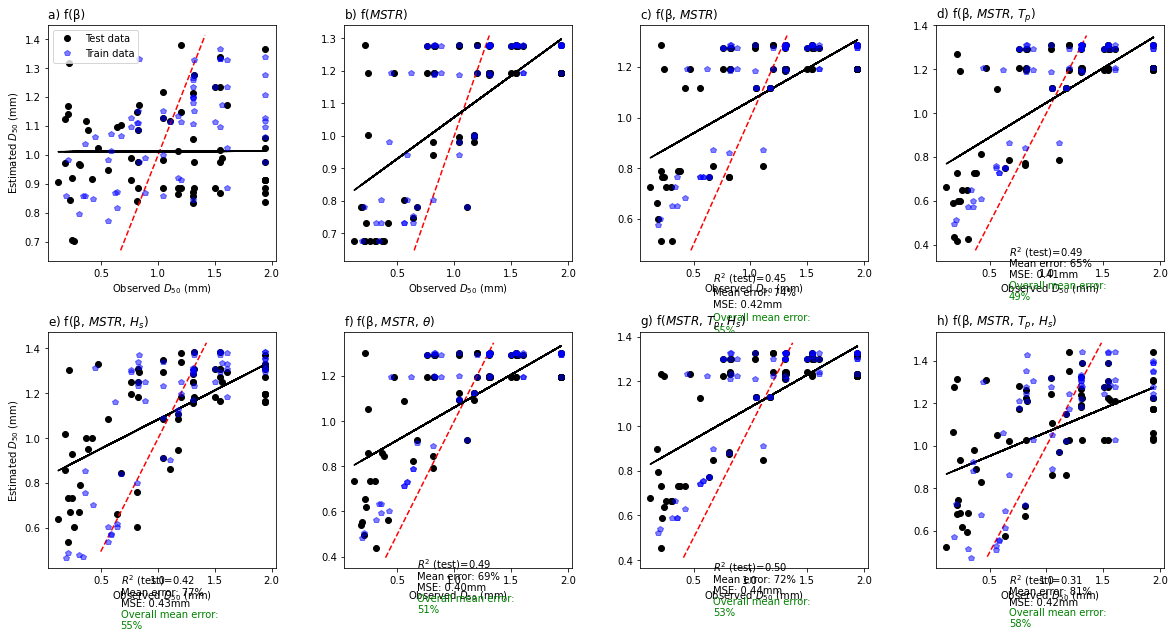

In [409]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.subplot(241)
ds_est = model1.predict(X_test1)
plt.plot(y_test1, ds_est, 'ko', label='Test data')
# plt.xlim(0.1,1.1); plt.ylim(.1,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"a) f(β)", loc='left')
r2 = np.min(np.corrcoef(y_test1, ds_est))**2
plt.text(.67,.35,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test1, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test1, poly1d_fn(y_test1), '-k')
plt.text(.67,.30, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test1,ds_est)))[:2]))
plt.text(.67,.25, r'MSE: {}mm'.format(str(Smean[0])[:4]))

ds_est2 = model1.predict(X_train1)
plt.plot(y_train1, ds_est2, 'bp', alpha=0.5, label='Train data')
plt.legend(loc=2)

plt.text(.67,.20, r'Overall mean error:', color='g')
plt.text(.67,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test1,y_train1)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(242)
ds_est = model2.predict(X_test2)
plt.plot(y_test2, ds_est, 'ko')
# plt.xlim(0.1,1.1); plt.ylim(.1,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"b) f($MSTR$)", loc='left')
r2 = np.min(np.corrcoef(y_test2, ds_est))**2
plt.text(.67,.35,r'$R^2$='+str(r2)[:4])

coef = np.polyfit(y_test2, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test2, poly1d_fn(y_test2), '-k')
plt.text(.67,.30, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test2,ds_est)))[:2]))
plt.text(.67,.25, r'MSE: {}mm'.format(str(Smean[1])[:4]))

ds_est2 = model2.predict(X_train2)
plt.plot(y_train2, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.67,.20, r'Overall mean error:', color='g')
plt.text(.67,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test2,y_train2)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(243)
ds_est = model3.predict(X_test3)
plt.plot(y_test3, ds_est, 'ko')
# plt.xlim(0.1,1.1); plt.ylim(.1,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title("c) f(β, $MSTR$)", loc='left')
r2 = np.min(np.corrcoef(y_test3, ds_est))**2
plt.text(.67,.35,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test3, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test3, poly1d_fn(y_test3), '-k')
plt.text(.67,.30, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test3,ds_est)))[:2]))
plt.text(.67,.25, r'MSE: {}mm'.format(str(Smean[2])[:4]))

ds_est2 = model3.predict(X_train3)
plt.plot(y_train3, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.67,.2, r'Overall mean error:', color='g')
plt.text(.67,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test3,y_train3)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(244)
ds_est = model4.predict(X_test4)
plt.plot(y_test4, ds_est, 'ko')
# plt.xlim(0.1,1.1); plt.ylim(.1,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.title(r"d) f(β, $MSTR$, $T_p$)", loc='left')
r2 = np.min(np.corrcoef(y_test4, ds_est))**2
plt.text(.67,.35,r'$R^2$ (test)='+str(r2)[:4])
plt.text(.67,.3, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test4,ds_est)))[:2]))
plt.text(.67,.25, r'MSE: {}mm'.format(str(Smean[3])[:4]))

coef = np.polyfit(y_test4, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test4, poly1d_fn(y_test4), '-k')

ds_est2 = model4.predict(X_train4)
plt.plot(y_train4, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.67,.2, r'Overall mean error:', color='g')
plt.text(.67,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test4,y_train4)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')


plt.subplot(245)
ds_est = model5.predict(X_test5)
plt.plot(y_test5, ds_est, 'ko')
# plt.xlim(0.1,1.1); plt.ylim(.1,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"e) f(β, $MSTR$, $H_s$)", loc='left')
r2 = np.min(np.corrcoef(y_test5, ds_est))**2
plt.text(.67,.35,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test5, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test5, poly1d_fn(y_test5), '-k')
plt.text(.67,.3, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test5,ds_est)))[:2]))
plt.text(.67,.25, r'MSE: {}mm'.format(str(Smean[4])[:4]))

ds_est2 = model5.predict(X_train5)
plt.plot(y_train5, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.67,.2, r'Overall mean error:', color='g')
plt.text(.67,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test5,y_train5)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')


plt.subplot(246)
ds_est = model6.predict(X_test6)
plt.plot(y_test6, ds_est, 'ko')
# plt.xlim(0.1,1.1); plt.ylim(.1,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"f) f(β, $MSTR$, $\theta$)", loc='left')
r2 = np.min(np.corrcoef(y_test6, ds_est))**2
plt.text(.67,.35,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test6, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test6, poly1d_fn(y_test6), '-k')
plt.text(.67,.3, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test6,ds_est)))[:2]))
plt.text(.67,.25, r'MSE: {}mm'.format(str(Smean[5])[:4]))

ds_est2 = model6.predict(X_train6)
plt.plot(y_train6, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.67,.2, r'Overall mean error:', color='g')
plt.text(.67,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test6,y_train6)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(247)
ds_est = model7.predict(X_test7)
plt.plot(y_test7, ds_est, 'ko')
# plt.xlim(0.1,1.1); plt.ylim(.1,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"g) f($MSTR$, $T_p$, $H_s$)", loc='left')
r2 = np.min(np.corrcoef(y_test7, ds_est))**2
plt.text(.67,.35,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test7, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test7, poly1d_fn(y_test7), '-k')
plt.text(.67,.3, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test7,ds_est)))[:2]))
plt.text(.67,.25, r'MSE: {}mm'.format(str(Smean[6])[:4]))

ds_est2 = model7.predict(X_train7)
plt.plot(y_train7, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.67,.2, r'Overall mean error:', color='g')
plt.text(.67,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test7,y_train7)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(248)
ds_est = model8.predict(X_test8)
plt.plot(y_test8, ds_est, 'ko')
# plt.xlim(0.1,1.1); plt.ylim(.1,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"h) f(β, $MSTR$, $T_p$, $H_s$)", loc='left')
r2 = np.min(np.corrcoef(y_test8, ds_est))**2
plt.text(.67,.35,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test8, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test8, poly1d_fn(y_test8), '-k')
plt.text(.67,.3, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test8,ds_est)))[:2]))
plt.text(.67,.25, r'MSE: {}mm'.format(str(Smean[7])[:4]))

ds_est2 = model8.predict(X_train8)
plt.plot(y_train8, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.67,.2, r'Overall mean error:', color='g')
plt.text(.67,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test8,y_train8)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')
#
# plt.savefig('../model_plots/SCali_d50-BF-8models-skill.jpg', dpi=300, bbox_inches='tight')
# plt.savefig('../model_plots/SCali_stratlat_d50-BF-8models-skill.jpg', dpi=300, bbox_inches='tight')
# plt.savefig('../model_plots/SCali_d50-BF-8models-skill-22-9-3.jpg', dpi=300, bbox_inches='tight')
plt.savefig('../model_plots/SCali_gs_d50-BF-8models-skill.jpg', dpi=300, bbox_inches='tight')


In [48]:
# np.save('../model_out/dataset_SCali_coast_BF_model1.npy', model1out, allow_pickle=True)
# np.save('../model_out/dataset_SCali_coast_BF_model2.npy', model2out, allow_pickle=True)
# np.save('../model_out/dataset_SCali_coast_BF_model3.npy', model3out, allow_pickle=True)
# np.save('../model_out/dataset_SCali_coast_BF_model4.npy', model4out, allow_pickle=True)
# np.save('../model_out/dataset_SCali_coast_BF_model5.npy', model5out, allow_pickle=True)
# np.save('../model_out/dataset_SCali_coast_BF_model6.npy', model6out, allow_pickle=True)
# np.save('../model_out/dataset_SCali_coast_BF_model7.npy', model7out, allow_pickle=True)
# np.save('../model_out/dataset_SCali_coast_BF_model8.npy', model8out, allow_pickle=True)

In [186]:
# np.save('../model_out/dataset_SCali_stratlat_coast_BF_model1.npy', model1out, allow_pickle=True)
# np.save('../model_out/dataset_SCali_stratlat_coast_BF_model2.npy', model2out, allow_pickle=True)
# np.save('../model_out/dataset_SCali_stratlat_coast_BF_model3.npy', model3out, allow_pickle=True)
# np.save('../model_out/dataset_SCali_stratlat_coast_BF_model4.npy', model4out, allow_pickle=True)
# np.save('../model_out/dataset_SCali_stratlat_coast_BF_model5.npy', model5out, allow_pickle=True)
# np.save('../model_out/dataset_SCali_stratlat_coast_BF_model6.npy', model6out, allow_pickle=True)
# np.save('../model_out/dataset_SCali_stratlat_coast_BF_model7.npy', model7out, allow_pickle=True)
# np.save('../model_out/dataset_SCali_stratlat_coast_BF_model8.npy', model8out, allow_pickle=True)

In [410]:
np.save('../model_out/dataset_SCali_stratgs_coast_BF_model1.npy', model1out, allow_pickle=True)
np.save('../model_out/dataset_SCali_stratgs_coast_BF_model2.npy', model2out, allow_pickle=True)
np.save('../model_out/dataset_SCali_stratgs_coast_BF_model3.npy', model3out, allow_pickle=True)
np.save('../model_out/dataset_SCali_stratgs_coast_BF_model4.npy', model4out, allow_pickle=True)
np.save('../model_out/dataset_SCali_stratgs_coast_BF_model5.npy', model5out, allow_pickle=True)
np.save('../model_out/dataset_SCali_stratgs_coast_BF_model6.npy', model6out, allow_pickle=True)
np.save('../model_out/dataset_SCali_stratgs_coast_BF_model7.npy', model7out, allow_pickle=True)
np.save('../model_out/dataset_SCali_stratgs_coast_BF_model8.npy', model8out, allow_pickle=True)

### midbeach only

In [411]:
# dfSCali = pd.read_csv('../../../orig_data/US_S_CA/SoCal_GrainSize_waves_slopes_tide_merged.csv')

In [412]:
# np.unique(dfSCali['Ele'])

array(['BB', 'BF', 'MB', 'O'], dtype=object)

In [413]:
dfSCali = df_strat_gs.copy()
len(dfSCali)

240

In [414]:
dfSCali = dfSCali[dfSCali['Grain_Size']<2] ## too few samples >1.0
dfSCali = dfSCali[dfSCali['Ele']=='MB']
dfSCali = dfSCali.dropna()

In [415]:
Smean = []
Sstd = []

test_size = 0.5

standardize = False

In [416]:
len(dfSCali)

71

(array([ 5.,  7., 14.,  3.,  6.,  6., 10.,  0.,  0., 20.]),
 array([0.1604    , 0.30992774, 0.45945548, 0.60898323, 0.75851097,
        0.90803871, 1.05756645, 1.2070942 , 1.35662194, 1.50614968,
        1.65567742]),
 <BarContainer object of 10 artists>)

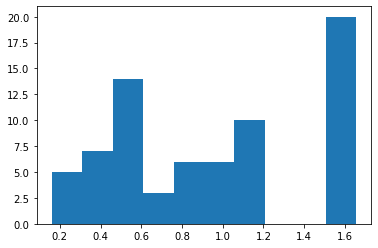

In [417]:
plt.hist(dfSCali['Grain_Size'])

In [418]:
rand = np.random.randn(len(dfSCali))
np.save('../model_out/SCali_randMB.npy', rand, allow_pickle=True)

### model 1

In [419]:
feature_names1 = ['β (radians)', 'Random\n (non-dim.)']
X = np.stack((dfSCali['Beach face slope'], rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X.T,dfSCali['Grain_Size'], test_size=test_size, random_state=2022  
    ## the varying seed is to better balance the test and train grain size ranges, which seems to be important
)

# X_train1, X_test1, y_train1, y_test1 = train_test_split(
#     X.T,y.ravel(), test_size=test_size, random_state=2022  ##dfEAus['d50']
# )

#unscale y - we balanced it to sample equally among grain size bins
# y_test1 = yscaler.inverse_transform(y_test1.reshape(-1, 1)).squeeze()
# y_train1 = yscaler.inverse_transform(y_train1.reshape(-1, 1)).squeeze()

print(y_test1.max())
print(y_train1.max())

# model1 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model1 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)

model1.fit(X_train1, y_train1)

mse1 = mean_squared_error(y_test1, model1.predict(X_test1))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse1))

1.655677425
1.655677425
Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
The mean squared error (MSE) on test set: 0.2838


In [420]:

print(model1.best_params_)
model1out = {}
model1out['feature_names'] = feature_names1
model1out['Xtest'] = X_test1
model1out['Xtrain'] = X_train1
model1out['ytest'] = y_test1
model1out['ytrain'] = y_train1
model1out['model'] = model1
model1out['mse'] = mse1
model1out['best_params'] = model1.best_params_

{'learning_rate': 0.1, 'loss': 'absolute_error', 'max_depth': 7, 'min_samples_split': 3, 'n_estimators': 500, 'subsample': 0.75}


In [421]:
model1 = model1.best_estimator_

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model1, X_test1, y_test1, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.489 (0.183)


### model 2

In [422]:
feature_names2 = [r'MSTR (m)', 'Random\n (non-dim.)']
X = np.stack((dfSCali['TIDAL_RANGE'], rand))

X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X.T, dfSCali['Grain_Size'], test_size=test_size, random_state=2022
)

# model2 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model2 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model2.fit(X_train2, y_train2)

mse2 = mean_squared_error(y_test2, model2.predict(X_test2))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse2))

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
The mean squared error (MSE) on test set: 0.2739


In [423]:
print(model2.best_params_)
model2out = {}
model2out['feature_names'] = feature_names2
model2out['Xtest'] = X_test2
model2out['Xtrain'] = X_train2
model2out['ytest'] = y_test2
model2out['ytrain'] = y_train2
model2out['model'] = model2
model2out['mse'] = mse2
model2out['best_params'] = model2.best_params_

{'learning_rate': 0.05, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 25, 'subsample': 1.0}


In [424]:
model2 = model2.best_estimator_

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model2, X_test2, y_test2, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.484 (0.230)


### model 3

In [425]:
feature_names3 = ['β (radians)','MSTR (m)', 'Random\n (non-dim.)']
X = np.stack((dfSCali['Beach face slope'], dfSCali['TIDAL_RANGE'], rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train3, X_test3, y_train3, y_test3 = train_test_split(
    X.T, dfSCali['Grain_Size'], test_size=test_size, random_state=2022
)

# model3 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model3 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model3.fit(X_train3, y_train3)

mse3 = mean_squared_error(y_test3, model3.predict(X_test3))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse3))

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
The mean squared error (MSE) on test set: 0.2471


In [426]:
print(model3.best_params_)
model3out = {}
model3out['feature_names'] = feature_names3
model3out['Xtest'] = X_test3
model3out['Xtrain'] = X_train3
model3out['ytest'] = y_test3
model3out['ytrain'] = y_train3
model3out['model'] = model3
model3out['mse'] = mse3
model3out['best_params'] = model3.best_params_

{'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 25, 'subsample': 1.0}


In [427]:
model3 = model3.best_estimator_

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model3, X_test3, y_test3, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.469 (0.228)


### model 4

In [428]:
feature_names4 = ['β (radians)','MSTR (m)',r'$T_p$ (s)', 'Random\n (non-dim.)']
X = np.stack((dfSCali['Beach face slope'], dfSCali['TIDAL_RANGE'], dfSCali['Tp'], rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train4, X_test4, y_train4, y_test4 = train_test_split(
    X.T, dfSCali['Grain_Size'], test_size=test_size, random_state=2022
)

# model4 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model4 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)

model4.fit(X_train4, y_train4)

mse4 = mean_squared_error(y_test4, model4.predict(X_test4))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse4))

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
The mean squared error (MSE) on test set: 0.3001


In [429]:
print(model4.best_params_)

model4out = {}
model4out['feature_names'] = feature_names4
model4out['Xtest'] = X_test4
model4out['Xtrain'] = X_train4
model4out['ytest'] = y_test4
model4out['ytrain'] = y_train4
model4out['model'] = model4
model4out['mse'] = mse4
model4out['best_params'] = model4.best_params_

{'learning_rate': 0.01, 'loss': 'absolute_error', 'max_depth': 7, 'min_samples_split': 3, 'n_estimators': 100, 'subsample': 1.0}


In [430]:
model4 = model4.best_estimator_

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model4, X_test4, y_test4, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.484 (0.199)


### model 5

In [431]:
feature_names5 = ['β (radians)','MSTR (m)',r'$H_s$ (m)', 'Random\n (non-dim.)']
X = np.stack((dfSCali['Beach face slope'], dfSCali['TIDAL_RANGE'], dfSCali['Hs'], rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train5, X_test5, y_train5, y_test5 = train_test_split(
    X.T, dfSCali['Grain_Size'], test_size=test_size, random_state=2022
)

# model5 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model5 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model5.fit(X_train5, y_train5)

mse5 = mean_squared_error(y_test5, model5.predict(X_test5))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse5))

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
The mean squared error (MSE) on test set: 0.3014


In [432]:
print(model5.best_params_)
model5out = {}
model5out['feature_names'] = feature_names5
model5out['Xtest'] = X_test5
model5out['Xtrain'] = X_train5
model5out['ytest'] = y_test5
model5out['ytrain'] = y_train5
model5out['model'] = model5
model5out['mse'] = mse5
model5out['best_params'] = model5.best_params_

{'learning_rate': 0.1, 'loss': 'absolute_error', 'max_depth': 9, 'min_samples_split': 3, 'n_estimators': 200, 'subsample': 1.0}


In [433]:
model5 = model5.best_estimator_

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model5, X_test5, y_test5, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.504 (0.248)


### model 6

In [434]:
feature_names6 = ['β (radians)','MSTR (m)',r'$\theta$ (deg.)', 'Random\n (non-dim.)']
X = np.stack((dfSCali['Beach face slope'], dfSCali['TIDAL_RANGE'], dfSCali['Dp'], rand))

X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train6, X_test6, y_train6, y_test6 = train_test_split(
    X.T, dfSCali['Grain_Size'], test_size=test_size, random_state=2022
)

# model6 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model6 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model6.fit(X_train6, y_train6)

mse6 = mean_squared_error(y_test6,model6.predict(X_test6))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse6))

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
The mean squared error (MSE) on test set: 0.2315


In [435]:
print(model6.best_params_)

model6out = {}
model6out['feature_names'] = feature_names6
model6out['Xtest'] = X_test6
model6out['Xtrain'] = X_train6
model6out['ytest'] = y_test6
model6out['ytrain'] = y_train6
model6out['model'] = model6
model6out['mse'] = mse6
model6out['best_params'] = model6.best_params_

{'learning_rate': 0.01, 'loss': 'huber', 'max_depth': 9, 'min_samples_split': 3, 'n_estimators': 200, 'subsample': 1.0}


In [436]:
model6 = model6.best_estimator_

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model6, X_test6, y_test6, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.456 (0.276)


### model 7

In [437]:
feature_names7 = ['MSTR (m)',r'$T_p$ (s)',r'$H_s$ (m)', 'Random\n (non-dim.)']
# X = np.stack((dfEAus['mstr'], dfEAus['tp'], dfEAus['hs_mean'],  rand))
X = np.stack((dfSCali['TIDAL_RANGE'], dfSCali['Tp'], dfSCali['Hs'], rand))

X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train7, X_test7, y_train7, y_test7 = train_test_split(
    X.T, dfSCali['Grain_Size'], test_size=test_size, random_state=2022
)

# model7 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model7 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model7.fit(X_train7, y_train7)

mse7 = mean_squared_error(y_test7,model7.predict(X_test7))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse7))

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
The mean squared error (MSE) on test set: 0.3243


In [438]:
print(model7.best_params_)

model7out = {}
model7out['feature_names'] = feature_names7
model7out['Xtest'] = X_test7
model7out['Xtrain'] = X_train7
model7out['ytest'] = y_test7
model7out['ytrain'] = y_train7
model7out['model'] = model7
model7out['mse'] = mse7
model7out['best_params'] = model7.best_params_

{'learning_rate': 0.1, 'loss': 'absolute_error', 'max_depth': 9, 'min_samples_split': 3, 'n_estimators': 500, 'subsample': 1.0}


In [439]:
model7 = model7.best_estimator_

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model7, X_test7, y_test7, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.511 (0.250)


### model 8

In [440]:
feature_names8 = ['β (radians)','MSTR (m)',r'$T_p$ (s)',r'$H_s$ (m)',  'Random\n (non-dim.)']
# X = np.stack((dfEAus['beach_slope_average'], dfEAus['mstr'], dfEAus['tp'], dfEAus['hs_mean'],  rand))
X = np.stack((dfSCali['Beach face slope'], dfSCali['TIDAL_RANGE'], dfSCali['Tp'], dfSCali['Hs'], rand))

X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train8, X_test8, y_train8, y_test8= train_test_split(
    X.T, dfSCali['Grain_Size'], test_size=test_size, random_state=2022
)

# model8= ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model8 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model8.fit(X_train8, y_train8)

mse8 = mean_squared_error(y_test8,model8.predict(X_test8))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse8))

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
The mean squared error (MSE) on test set: 0.2860


In [441]:
print(model8.best_params_)

model8out = {}
model8out['feature_names'] = feature_names8
model8out['Xtest'] = X_test8
model8out['Xtrain'] = X_train8
model8out['ytest'] = y_test8
model8out['ytrain'] = y_train8
model8out['model'] = model8.best_estimator_
model8out['mse'] = mse8
model8out['best_params'] = model8.best_params_

{'learning_rate': 0.05, 'loss': 'absolute_error', 'max_depth': 9, 'min_samples_split': 3, 'n_estimators': 25, 'subsample': 1.0}


In [442]:
model8 = model8.best_estimator_

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model8, X_test8, y_test8, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)

print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.497 (0.224)


### plot

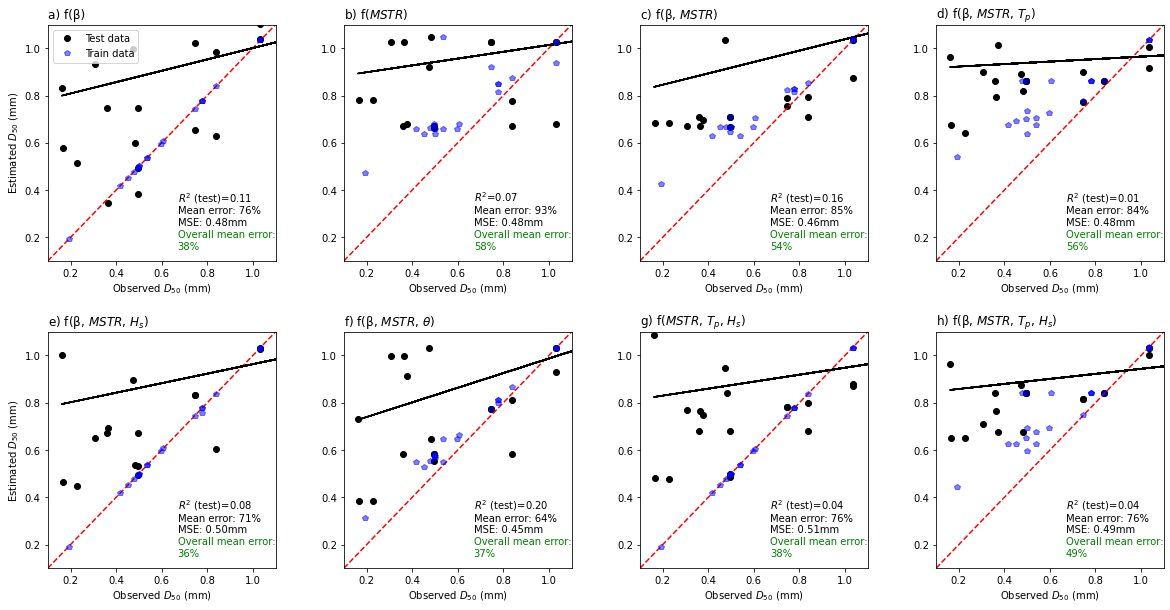

In [443]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.subplot(241)
ds_est = model1.predict(X_test1)
plt.plot(y_test1, ds_est, 'ko', label='Test data')
plt.xlim(0.1,1.1); plt.ylim(.1,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"a) f(β)", loc='left')
r2 = np.min(np.corrcoef(y_test1, ds_est))**2
plt.text(.67,.35,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test1, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test1, poly1d_fn(y_test1), '-k')
plt.text(.67,.30, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test1,ds_est)))[:2]))
plt.text(.67,.25, r'MSE: {}mm'.format(str(Smean[0])[:4]))

ds_est2 = model1.predict(X_train1)
plt.plot(y_train1, ds_est2, 'bp', alpha=0.5, label='Train data')
plt.legend(loc=2)

plt.text(.67,.20, r'Overall mean error:', color='g')
plt.text(.67,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test1,y_train1)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(242)
ds_est = model2.predict(X_test2)
plt.plot(y_test2, ds_est, 'ko')
plt.xlim(0.1,1.1); plt.ylim(.1,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"b) f($MSTR$)", loc='left')
r2 = np.min(np.corrcoef(y_test2, ds_est))**2
plt.text(.67,.35,r'$R^2$='+str(r2)[:4])

coef = np.polyfit(y_test2, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test2, poly1d_fn(y_test2), '-k')
plt.text(.67,.30, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test2,ds_est)))[:2]))
plt.text(.67,.25, r'MSE: {}mm'.format(str(Smean[1])[:4]))

ds_est2 = model2.predict(X_train2)
plt.plot(y_train2, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.67,.20, r'Overall mean error:', color='g')
plt.text(.67,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test2,y_train2)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(243)
ds_est = model3.predict(X_test3)
plt.plot(y_test3, ds_est, 'ko')
plt.xlim(0.1,1.1); plt.ylim(.1,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title("c) f(β, $MSTR$)", loc='left')
r2 = np.min(np.corrcoef(y_test3, ds_est))**2
plt.text(.67,.35,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test3, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test3, poly1d_fn(y_test3), '-k')
plt.text(.67,.30, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test3,ds_est)))[:2]))
plt.text(.67,.25, r'MSE: {}mm'.format(str(Smean[2])[:4]))

ds_est2 = model3.predict(X_train3)
plt.plot(y_train3, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.67,.2, r'Overall mean error:', color='g')
plt.text(.67,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test3,y_train3)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(244)
ds_est = model4.predict(X_test4)
plt.plot(y_test4, ds_est, 'ko')
plt.xlim(0.1,1.1); plt.ylim(.1,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.title(r"d) f(β, $MSTR$, $T_p$)", loc='left')
r2 = np.min(np.corrcoef(y_test4, ds_est))**2
plt.text(.67,.35,r'$R^2$ (test)='+str(r2)[:4])
plt.text(.67,.3, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test4,ds_est)))[:2]))
plt.text(.67,.25, r'MSE: {}mm'.format(str(Smean[3])[:4]))

coef = np.polyfit(y_test4, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test4, poly1d_fn(y_test4), '-k')

ds_est2 = model4.predict(X_train4)
plt.plot(y_train4, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.67,.2, r'Overall mean error:', color='g')
plt.text(.67,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test4,y_train4)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')


plt.subplot(245)
ds_est = model5.predict(X_test5)
plt.plot(y_test5, ds_est, 'ko')
plt.xlim(0.1,1.1); plt.ylim(.1,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"e) f(β, $MSTR$, $H_s$)", loc='left')
r2 = np.min(np.corrcoef(y_test5, ds_est))**2
plt.text(.67,.35,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test5, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test5, poly1d_fn(y_test5), '-k')
plt.text(.67,.3, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test5,ds_est)))[:2]))
plt.text(.67,.25, r'MSE: {}mm'.format(str(Smean[4])[:4]))

ds_est2 = model5.predict(X_train5)
plt.plot(y_train5, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.67,.2, r'Overall mean error:', color='g')
plt.text(.67,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test5,y_train5)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')


plt.subplot(246)
ds_est = model6.predict(X_test6)
plt.plot(y_test6, ds_est, 'ko')
plt.xlim(0.1,1.1); plt.ylim(.1,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"f) f(β, $MSTR$, $\theta$)", loc='left')
r2 = np.min(np.corrcoef(y_test6, ds_est))**2
plt.text(.67,.35,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test6, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test6, poly1d_fn(y_test6), '-k')
plt.text(.67,.3, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test6,ds_est)))[:2]))
plt.text(.67,.25, r'MSE: {}mm'.format(str(Smean[5])[:4]))

ds_est2 = model6.predict(X_train6)
plt.plot(y_train6, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.67,.2, r'Overall mean error:', color='g')
plt.text(.67,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test6,y_train6)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(247)
ds_est = model7.predict(X_test7)
plt.plot(y_test7, ds_est, 'ko')
plt.xlim(0.1,1.1); plt.ylim(.1,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"g) f($MSTR$, $T_p$, $H_s$)", loc='left')
r2 = np.min(np.corrcoef(y_test7, ds_est))**2
plt.text(.67,.35,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test7, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test7, poly1d_fn(y_test7), '-k')
plt.text(.67,.3, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test7,ds_est)))[:2]))
plt.text(.67,.25, r'MSE: {}mm'.format(str(Smean[6])[:4]))

ds_est2 = model7.predict(X_train7)
plt.plot(y_train7, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.67,.2, r'Overall mean error:', color='g')
plt.text(.67,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test7,y_train7)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(248)
ds_est = model8.predict(X_test8)
plt.plot(y_test8, ds_est, 'ko')
plt.xlim(0.1,1.1); plt.ylim(.1,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"h) f(β, $MSTR$, $T_p$, $H_s$)", loc='left')
r2 = np.min(np.corrcoef(y_test8, ds_est))**2
plt.text(.67,.35,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test8, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test8, poly1d_fn(y_test8), '-k')
plt.text(.67,.3, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test8,ds_est)))[:2]))
plt.text(.67,.25, r'MSE: {}mm'.format(str(Smean[7])[:4]))

ds_est2 = model8.predict(X_train8)
plt.plot(y_train8, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.67,.2, r'Overall mean error:', color='g')
plt.text(.67,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test8,y_train8)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')
#
# plt.savefig('../model_plots/SCali_MB_d50-8models-skill.jpg', dpi=300, bbox_inches='tight')
plt.savefig('../model_plots/SCali_MB_d50-8models-skill-2022-9-3.jpg', dpi=300, bbox_inches='tight')



In [85]:
# np.save('../model_out/dataset_SCali_coast_MB_model1.npy', model1out, allow_pickle=True)
# np.save('../model_out/dataset_SCali_coast_MB_model2.npy', model2out, allow_pickle=True)
# np.save('../model_out/dataset_SCali_coast_MB_model3.npy', model3out, allow_pickle=True)
# np.save('../model_out/dataset_SCali_coast_MB_model4.npy', model4out, allow_pickle=True)
# np.save('../model_out/dataset_SCali_coast_MB_model5.npy', model5out, allow_pickle=True)
# np.save('../model_out/dataset_SCali_coast_MB_model6.npy', model6out, allow_pickle=True)
# np.save('../model_out/dataset_SCali_coast_MB_model7.npy', model7out, allow_pickle=True)
# np.save('../model_out/dataset_SCali_coast_MB_model8.npy', model8out, allow_pickle=True)

In [444]:
np.save('../model_out/dataset_SCali_coast_MB_model1-22-9-3.npy', model1out, allow_pickle=True)
np.save('../model_out/dataset_SCali_coast_MB_model2-22-9-3.npy', model2out, allow_pickle=True)
np.save('../model_out/dataset_SCali_coast_MB_model3-22-9-3.npy', model3out, allow_pickle=True)
np.save('../model_out/dataset_SCali_coast_MB_model4-22-9-3.npy', model4out, allow_pickle=True)
np.save('../model_out/dataset_SCali_coast_MB_model5-22-9-3.npy', model5out, allow_pickle=True)
np.save('../model_out/dataset_SCali_coast_MB_model6-22-9-3.npy', model6out, allow_pickle=True)
np.save('../model_out/dataset_SCali_coast_MB_model7-22-9-3.npy', model7out, allow_pickle=True)
np.save('../model_out/dataset_SCali_coast_MB_model8-22-9-3.npy', model8out, allow_pickle=True)

### beachface and midbeach samples

In [105]:
# dfSCali = pd.read_csv('../../../orig_data/US_S_CA/SoCal_GrainSize_waves_slopes_tide_merged.csv')

In [445]:
dfSCali = df_strat_gs.copy()
len(dfSCali)

240

In [446]:
dfSCali = dfSCali[dfSCali['Grain_Size']<2.0] ## too few samples >1.0
dfSCali = dfSCali[(dfSCali['Ele']=='MB') | (dfSCali['Ele']=='BF')]
dfSCali = dfSCali.dropna()

In [447]:
len(dfSCali)

204

In [448]:
Smean = []
Sstd = []

test_size = 0.5

standardize = False

In [449]:
rand = np.random.randn(len(dfSCali))
np.save('../model_out/SCali_randMB_plus_BF.npy', rand, allow_pickle=True)

### model 1

In [450]:
feature_names1 = ['β (radians)', 'Random\n (non-dim.)']
X = np.stack((dfSCali['Beach face slope'], rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X.T,dfSCali['Grain_Size'], test_size=test_size, random_state=42 ##
)

# X_train1, X_test1, y_train1, y_test1 = train_test_split(
#     X.T,y.ravel(), test_size=test_size, random_state=2022  ##dfEAus['d50']
# )

#unscale y - we balanced it to sample equally among grain size bins
# y_test1 = yscaler.inverse_transform(y_test1.reshape(-1, 1)).squeeze()
# y_train1 = yscaler.inverse_transform(y_train1.reshape(-1, 1)).squeeze()

print(y_test1.max())
print(y_train1.max())

# model1 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model1 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)

model1.fit(X_train1, y_train1)

mse1 = mean_squared_error(y_test1, model1.predict(X_test1))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse1))

1.942912168
1.942912168
Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
The mean squared error (MSE) on test set: 0.3244


In [451]:

print(model1.best_params_)
model1out = {}
model1out['feature_names'] = feature_names1
model1out['Xtest'] = X_test1
model1out['Xtrain'] = X_train1
model1out['ytest'] = y_test1
model1out['ytrain'] = y_train1
model1out['model'] = model1
model1out['mse'] = mse1
model1out['best_params'] = model1.best_params_

{'learning_rate': 0.01, 'loss': 'absolute_error', 'max_depth': 3, 'min_samples_split': 9, 'n_estimators': 200, 'subsample': 1.0}


In [452]:
model1 = model1.best_estimator_

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model1, X_test1, y_test1, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.539 (0.085)


### model 2

In [453]:
feature_names2 = [r'MSTR (m)', 'Random\n (non-dim.)']
X = np.stack((dfSCali['TIDAL_RANGE'], rand))

X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X.T, dfSCali['Grain_Size'], test_size=test_size, random_state=42
)

# model2 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model2 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model2.fit(X_train2, y_train2)

mse2 = mean_squared_error(y_test2, model2.predict(X_test2))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse2))

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
The mean squared error (MSE) on test set: 0.2427


In [454]:
print(model2.best_params_)
model2out = {}
model2out['feature_names'] = feature_names2
model2out['Xtest'] = X_test2
model2out['Xtrain'] = X_train2
model2out['ytest'] = y_test2
model2out['ytrain'] = y_train2
model2out['model'] = model2
model2out['mse'] = mse2
model2out['best_params'] = model2.best_params_

{'learning_rate': 0.05, 'loss': 'squared_error', 'max_depth': 3, 'min_samples_split': 3, 'n_estimators': 50, 'subsample': 1.0}


In [455]:
model2 = model2.best_estimator_

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model2, X_test2, y_test2, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.480 (0.080)


### model 3

In [456]:
feature_names3 = ['β (radians)','MSTR (m)', 'Random\n (non-dim.)']
X = np.stack((dfSCali['Beach face slope'], dfSCali['TIDAL_RANGE'], rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train3, X_test3, y_train3, y_test3 = train_test_split(
    X.T, dfSCali['Grain_Size'], test_size=test_size, random_state=2022
)

# model3 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model3 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model3.fit(X_train3, y_train3)

mse3 = mean_squared_error(y_test3, model3.predict(X_test3))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse3))

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
The mean squared error (MSE) on test set: 0.2273


In [457]:
print(model3.best_params_)
model3out = {}
model3out['feature_names'] = feature_names3
model3out['Xtest'] = X_test3
model3out['Xtrain'] = X_train3
model3out['ytest'] = y_test3
model3out['ytrain'] = y_train3
model3out['model'] = model3
model3out['mse'] = mse3
model3out['best_params'] = model3.best_params_

{'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 3, 'min_samples_split': 3, 'n_estimators': 50, 'subsample': 1.0}


In [458]:
model3 = model3.best_estimator_

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model3, X_test3, y_test3, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.442 (0.082)


### model 4

In [459]:
feature_names4 = ['β (radians)','MSTR (m)',r'$T_p$ (s)', 'Random\n (non-dim.)']
X = np.stack((dfSCali['Beach face slope'], dfSCali['TIDAL_RANGE'], dfSCali['Tp'], rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train4, X_test4, y_train4, y_test4 = train_test_split(
    X.T, dfSCali['Grain_Size'], test_size=test_size, random_state=2022
)

# model4 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model4 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)

model4.fit(X_train4, y_train4)

mse4 = mean_squared_error(y_test4, model4.predict(X_test4))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse4))

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
The mean squared error (MSE) on test set: 0.2034


In [460]:
print(model4.best_params_)

model4out = {}
model4out['feature_names'] = feature_names4
model4out['Xtest'] = X_test4
model4out['Xtrain'] = X_train4
model4out['ytest'] = y_test4
model4out['ytrain'] = y_train4
model4out['model'] = model4
model4out['mse'] = mse4
model4out['best_params'] = model4.best_params_

{'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 3, 'min_samples_split': 7, 'n_estimators': 50, 'subsample': 0.75}


In [461]:
model4 = model4.best_estimator_

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model4, X_test4, y_test4, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.433 (0.083)


### model 5

In [462]:
feature_names5 = ['β (radians)','MSTR (m)',r'$H_s$ (m)', 'Random\n (non-dim.)']
X = np.stack((dfSCali['Beach face slope'], dfSCali['TIDAL_RANGE'], dfSCali['Hs'], rand))
X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train5, X_test5, y_train5, y_test5 = train_test_split(
    X.T, dfSCali['Grain_Size'], test_size=test_size, random_state=2022
)

# model5 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model5 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model5.fit(X_train5, y_train5)

mse5 = mean_squared_error(y_test5, model5.predict(X_test5))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse5))

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
The mean squared error (MSE) on test set: 0.2059


In [463]:
print(model5.best_params_)
model5out = {}
model5out['feature_names'] = feature_names5
model5out['Xtest'] = X_test5
model5out['Xtrain'] = X_train5
model5out['ytest'] = y_test5
model5out['ytrain'] = y_train5
model5out['model'] = model5
model5out['mse'] = mse5
model5out['best_params'] = model5.best_params_

{'learning_rate': 0.01, 'loss': 'huber', 'max_depth': 3, 'min_samples_split': 3, 'n_estimators': 200, 'subsample': 1.0}


In [464]:
model5 = model5.best_estimator_

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model5, X_test5, y_test5, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.436 (0.083)


### model 6

In [465]:
feature_names6 = ['β (radians)','MSTR (m)',r'$\theta$ (deg.)', 'Random\n (non-dim.)']
X = np.stack((dfSCali['Beach face slope'], dfSCali['TIDAL_RANGE'], dfSCali['Dp'], rand))

X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train6, X_test6, y_train6, y_test6 = train_test_split(
    X.T, dfSCali['Grain_Size'], test_size=test_size, random_state=2022
)

# model6 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model6 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model6.fit(X_train6, y_train6)

mse6 = mean_squared_error(y_test6,model6.predict(X_test6))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse6))

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
The mean squared error (MSE) on test set: 0.2188


In [466]:
print(model6.best_params_)

model6out = {}
model6out['feature_names'] = feature_names6
model6out['Xtest'] = X_test6
model6out['Xtrain'] = X_train6
model6out['ytest'] = y_test6
model6out['ytrain'] = y_train6
model6out['model'] = model6
model6out['mse'] = mse6
model6out['best_params'] = model6.best_params_

{'learning_rate': 0.01, 'loss': 'squared_error', 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.75}


In [467]:
model6 = model6.best_estimator_

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model6, X_test6, y_test6, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.441 (0.083)


### model 7

In [468]:
feature_names7 = ['MSTR (m)',r'$T_p$ (s)',r'$H_s$ (m)', 'Random\n (non-dim.)']
# X = np.stack((dfEAus['mstr'], dfEAus['tp'], dfEAus['hs_mean'],  rand))
X = np.stack((dfSCali['TIDAL_RANGE'], dfSCali['Tp'], dfSCali['Hs'], rand))

X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train7, X_test7, y_train7, y_test7 = train_test_split(
    X.T, dfSCali['Grain_Size'], test_size=test_size, random_state=2022
)

# model7 = ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model7 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model7.fit(X_train7, y_train7)

mse7 = mean_squared_error(y_test7,model7.predict(X_test7))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse7))

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
The mean squared error (MSE) on test set: 0.2045


In [469]:
print(model7.best_params_)

model7out = {}
model7out['feature_names'] = feature_names7
model7out['Xtest'] = X_test7
model7out['Xtrain'] = X_train7
model7out['ytest'] = y_test7
model7out['ytrain'] = y_train7
model7out['model'] = model7
model7out['mse'] = mse7
model7out['best_params'] = model7.best_params_

{'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 3, 'min_samples_split': 9, 'n_estimators': 25, 'subsample': 1.0}


In [470]:
model7 = model7.best_estimator_

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model7, X_test7, y_test7, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.431 (0.081)


### model 8

In [471]:
feature_names8 = ['β (radians)','MSTR (m)',r'$T_p$ (s)',r'$H_s$ (m)',  'Random\n (non-dim.)']
# X = np.stack((dfEAus['beach_slope_average'], dfEAus['mstr'], dfEAus['tp'], dfEAus['hs_mean'],  rand))
X = np.stack((dfSCali['Beach face slope'], dfSCali['TIDAL_RANGE'], dfSCali['Tp'], dfSCali['Hs'], rand))

X.shape

if standardize:
    xscaler = preprocessing.StandardScaler().fit(X)
    X = xscaler.transform(X)
    print('Covariates standardized')

X_train8, X_test8, y_train8, y_test8= train_test_split(
    X.T, dfSCali['Grain_Size'], test_size=test_size, random_state=2022
)

# model8= ensemble.GradientBoostingRegressor(**params)
gbr = ensemble.GradientBoostingRegressor()#**params)

model8 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
model8.fit(X_train8, y_train8)

mse8 = mean_squared_error(y_test8,model8.predict(X_test8))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse8))

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
The mean squared error (MSE) on test set: 0.1970


In [472]:
print(model8.best_params_)

model8out = {}
model8out['feature_names'] = feature_names8
model8out['Xtest'] = X_test8
model8out['Xtrain'] = X_train8
model8out['ytest'] = y_test8
model8out['ytrain'] = y_train8
model8out['model'] = model8.best_estimator_
model8out['mse'] = mse8
model8out['best_params'] = model8.best_params_

{'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 3, 'min_samples_split': 9, 'n_estimators': 50, 'subsample': 1.0}


In [473]:
model8 = model8.best_estimator_

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# evaluate model
scores = cross_val_score(model8, X_test8, y_test8, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = np.absolute(scores)

print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Smean.append(scores.mean())
Sstd.append(scores.std())

Mean RMSE: 0.429 (0.082)


### plot

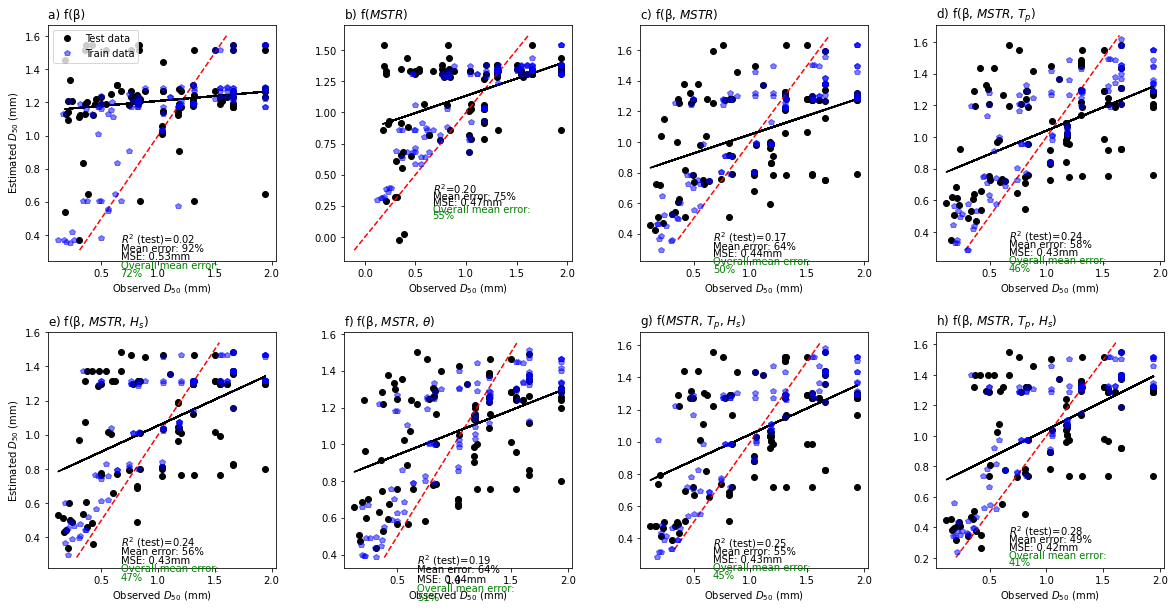

In [475]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.subplot(241)
ds_est = model1.predict(X_test1)
plt.plot(y_test1, ds_est, 'ko', label='Test data')
# plt.xlim(0.1,1.1); plt.ylim(.1,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"a) f(β)", loc='left')
r2 = np.min(np.corrcoef(y_test1, ds_est))**2
plt.text(.67,.35,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test1, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test1, poly1d_fn(y_test1), '-k')
plt.text(.67,.30, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test1,ds_est)))[:2]))
plt.text(.67,.25, r'MSE: {}mm'.format(str(Smean[0])[:4]))

ds_est2 = model1.predict(X_train1)
plt.plot(y_train1, ds_est2, 'bp', alpha=0.5, label='Train data')
plt.legend(loc=2)

plt.text(.67,.20, r'Overall mean error:', color='g')
plt.text(.67,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test1,y_train1)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(242)
ds_est = model2.predict(X_test2)
plt.plot(y_test2, ds_est, 'ko')
# plt.xlim(0.1,1.1); plt.ylim(.1,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"b) f($MSTR$)", loc='left')
r2 = np.min(np.corrcoef(y_test2, ds_est))**2
plt.text(.67,.35,r'$R^2$='+str(r2)[:4])

coef = np.polyfit(y_test2, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test2, poly1d_fn(y_test2), '-k')
plt.text(.67,.30, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test2,ds_est)))[:2]))
plt.text(.67,.25, r'MSE: {}mm'.format(str(Smean[1])[:4]))

ds_est2 = model2.predict(X_train2)
plt.plot(y_train2, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.67,.20, r'Overall mean error:', color='g')
plt.text(.67,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test2,y_train2)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(243)
ds_est = model3.predict(X_test3)
plt.plot(y_test3, ds_est, 'ko')
# plt.xlim(0.1,1.1); plt.ylim(.1,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title("c) f(β, $MSTR$)", loc='left')
r2 = np.min(np.corrcoef(y_test3, ds_est))**2
plt.text(.67,.35,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test3, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test3, poly1d_fn(y_test3), '-k')
plt.text(.67,.30, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test3,ds_est)))[:2]))
plt.text(.67,.25, r'MSE: {}mm'.format(str(Smean[2])[:4]))

ds_est2 = model3.predict(X_train3)
plt.plot(y_train3, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.67,.2, r'Overall mean error:', color='g')
plt.text(.67,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test3,y_train3)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(244)
ds_est = model4.predict(X_test4)
plt.plot(y_test4, ds_est, 'ko')
# plt.xlim(0.1,1.1); plt.ylim(.1,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.title(r"d) f(β, $MSTR$, $T_p$)", loc='left')
r2 = np.min(np.corrcoef(y_test4, ds_est))**2
plt.text(.67,.35,r'$R^2$ (test)='+str(r2)[:4])
plt.text(.67,.3, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test4,ds_est)))[:2]))
plt.text(.67,.25, r'MSE: {}mm'.format(str(Smean[3])[:4]))

coef = np.polyfit(y_test4, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test4, poly1d_fn(y_test4), '-k')

ds_est2 = model4.predict(X_train4)
plt.plot(y_train4, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.67,.2, r'Overall mean error:', color='g')
plt.text(.67,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test4,y_train4)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')


plt.subplot(245)
ds_est = model5.predict(X_test5)
plt.plot(y_test5, ds_est, 'ko')
# plt.xlim(0.1,1.1); plt.ylim(.1,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"e) f(β, $MSTR$, $H_s$)", loc='left')
r2 = np.min(np.corrcoef(y_test5, ds_est))**2
plt.text(.67,.35,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test5, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test5, poly1d_fn(y_test5), '-k')
plt.text(.67,.3, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test5,ds_est)))[:2]))
plt.text(.67,.25, r'MSE: {}mm'.format(str(Smean[4])[:4]))

ds_est2 = model5.predict(X_train5)
plt.plot(y_train5, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.67,.2, r'Overall mean error:', color='g')
plt.text(.67,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test5,y_train5)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')


plt.subplot(246)
ds_est = model6.predict(X_test6)
plt.plot(y_test6, ds_est, 'ko')
# plt.xlim(0.1,1.1); plt.ylim(.1,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"f) f(β, $MSTR$, $\theta$)", loc='left')
r2 = np.min(np.corrcoef(y_test6, ds_est))**2
plt.text(.67,.35,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test6, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test6, poly1d_fn(y_test6), '-k')
plt.text(.67,.3, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test6,ds_est)))[:2]))
plt.text(.67,.25, r'MSE: {}mm'.format(str(Smean[5])[:4]))

ds_est2 = model6.predict(X_train6)
plt.plot(y_train6, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.67,.2, r'Overall mean error:', color='g')
plt.text(.67,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test6,y_train6)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(247)
ds_est = model7.predict(X_test7)
plt.plot(y_test7, ds_est, 'ko')
# plt.xlim(0.1,1.1); plt.ylim(.1,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"g) f($MSTR$, $T_p$, $H_s$)", loc='left')
r2 = np.min(np.corrcoef(y_test7, ds_est))**2
plt.text(.67,.35,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test7, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test7, poly1d_fn(y_test7), '-k')
plt.text(.67,.3, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test7,ds_est)))[:2]))
plt.text(.67,.25, r'MSE: {}mm'.format(str(Smean[6])[:4]))

ds_est2 = model7.predict(X_train7)
plt.plot(y_train7, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.67,.2, r'Overall mean error:', color='g')
plt.text(.67,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test7,y_train7)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')

plt.subplot(248)
ds_est = model8.predict(X_test8)
plt.plot(y_test8, ds_est, 'ko')
# plt.xlim(0.1,1.1); plt.ylim(.1,1.1)
yl=plt.ylim()
plt.plot(yl,yl,'--r')
plt.xlabel(r'Observed $D_{50}$ (mm)')
# plt.ylabel(r'Estimated $D_{50}$ (mm)')
plt.title(r"h) f(β, $MSTR$, $T_p$, $H_s$)", loc='left')
r2 = np.min(np.corrcoef(y_test8, ds_est))**2
plt.text(.67,.35,r'$R^2$ (test)='+str(r2)[:4])

coef = np.polyfit(y_test8, ds_est,1)
poly1d_fn = np.poly1d(coef) 
plt.plot(y_test8, poly1d_fn(y_test8), '-k')
plt.text(.67,.3, r'Mean error: {}%'.format(str(np.mean(prc_err(y_test8,ds_est)))[:2]))
plt.text(.67,.25, r'MSE: {}mm'.format(str(Smean[7])[:4]))

ds_est2 = model8.predict(X_train8)
plt.plot(y_train8, ds_est2, 'bp', alpha=0.5, label='Train data')

plt.text(.67,.2, r'Overall mean error:', color='g')
plt.text(.67,.15, r'{}%'.format(str(np.mean(prc_err(np.hstack((y_test8,y_train8)),np.hstack((ds_est,ds_est2)))))[:2]), color='g')
#
# plt.savefig('../model_plots/SCali_MB_plus_BF_d50-8models-skill.jpg', dpi=300, bbox_inches='tight')
# plt.savefig('../model_plots/SCali_MB_plus_BF_d50-8models-skill-2022-08-31.jpg', dpi=300, bbox_inches='tight')
plt.savefig('../model_plots/SCali_MB_plus_BF_d50-8models-skill-2022-9-3.jpg', dpi=300, bbox_inches='tight')


### offshore only

In [125]:
# dfSCali = pd.read_csv('../../../orig_data/US_S_CA/SoCal_GrainSize_waves_slopes_tide_merged.csv')

In [87]:
# dfSCali = dfSCali[dfSCali['Grain_Size']<1.0] ## too few samples >1.0
# dfSCali = dfSCali[dfSCali['Ele']=='O']
# dfSCali = dfSCali.dropna()

In [88]:
# Smean = []
# Sstd = []

# test_size = 0.5

# standardize = False

In [89]:
# len(dfSCali)

358

In [90]:
# rand = np.random.randn(len(dfSCali))
# np.save('../model_out/SCali_randMB.npy', rand, allow_pickle=True)

### model 1

In [99]:
# feature_names1 = ['β (radians)', 'Random\n (non-dim.)']
# X = np.stack((dfSCali['Beach face slope'], rand))
# X.shape

# if standardize:
#     xscaler = preprocessing.StandardScaler().fit(X)
#     X = xscaler.transform(X)
#     print('Covariates standardized')

# X_train1, X_test1, y_train1, y_test1 = train_test_split(
#     X.T,dfSCali['Grain_Size'], test_size=test_size, random_state=42 ##
# )

# # X_train1, X_test1, y_train1, y_test1 = train_test_split(
# #     X.T,y.ravel(), test_size=test_size, random_state=2022  ##dfEAus['d50']
# # )

# #unscale y - we balanced it to sample equally among grain size bins
# # y_test1 = yscaler.inverse_transform(y_test1.reshape(-1, 1)).squeeze()
# # y_train1 = yscaler.inverse_transform(y_train1.reshape(-1, 1)).squeeze()

# print(y_test1.max())
# print(y_train1.max())

# # model1 = ensemble.GradientBoostingRegressor(**params)
# gbr = ensemble.GradientBoostingRegressor()#**params)

# model1 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)

# model1.fit(X_train1, y_train1)

# mse1 = mean_squared_error(y_test1, model1.predict(X_test1))
# print("The mean squared error (MSE) on test set: {:.4f}".format(mse1))

0.7083
0.865
Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
The mean squared error (MSE) on test set: 0.0049


In [100]:

# print(model1.best_params_)
# model1out = {}
# model1out['feature_names'] = feature_names1
# model1out['Xtest'] = X_test1
# model1out['Xtrain'] = X_train1
# model1out['ytest'] = y_test1
# model1out['ytrain'] = y_train1
# model1out['model'] = model1
# model1out['mse'] = mse1
# model1out['best_params'] = model1.best_params_

{'learning_rate': 0.01, 'loss': 'squared_error', 'max_depth': 3, 'min_samples_split': 3, 'n_estimators': 25, 'subsample': 1.0}


In [ ]:
# model1 = model1.best_estimator_

# cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# # evaluate model
# scores = cross_val_score(model1, X_test1, y_test1, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# # force scores to be positive
# scores = np.absolute(scores)
# print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

# Smean.append(scores.mean())
# Sstd.append(scores.std())

### model 2

In [101]:
# feature_names2 = [r'MSTR (m)', 'Random\n (non-dim.)']
# X = np.stack((dfSCali['TIDAL_RANGE'], rand))

# X.shape

# if standardize:
#     xscaler = preprocessing.StandardScaler().fit(X)
#     X = xscaler.transform(X)
#     print('Covariates standardized')

# X_train2, X_test2, y_train2, y_test2 = train_test_split(
#     X.T, dfSCali['Grain_Size'], test_size=test_size, random_state=42
# )

# # model2 = ensemble.GradientBoostingRegressor(**params)
# gbr = ensemble.GradientBoostingRegressor()#**params)

# model2 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
# model2.fit(X_train2, y_train2)

# mse2 = mean_squared_error(y_test2, model2.predict(X_test2))
# print("The mean squared error (MSE) on test set: {:.4f}".format(mse2))

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
The mean squared error (MSE) on test set: 0.0048


In [102]:
# print(model2.best_params_)
# model2out = {}
# model2out['feature_names'] = feature_names2
# model2out['Xtest'] = X_test2
# model2out['Xtrain'] = X_train2
# model2out['ytest'] = y_test2
# model2out['ytrain'] = y_train2
# model2out['model'] = model2
# model2out['mse'] = mse2
# model2out['best_params'] = model2.best_params_

{'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 9, 'min_samples_split': 7, 'n_estimators': 25, 'subsample': 0.5}


In [103]:
# model2 = model2.best_estimator_

# cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=2022)
# # evaluate model
# scores = cross_val_score(model2, X_test2, y_test2, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)

# # force scores to be positive
# scores = np.absolute(scores)
# print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

# Smean.append(scores.mean())
# Sstd.append(scores.std())

Mean RMSE: 0.063 (0.026)


### model 3

In [118]:
# feature_names3 = ['β (radians)','MSTR (m)', 'Random\n (non-dim.)']
# X = np.stack((dfSCali['Beach face slope'], dfSCali['TIDAL_RANGE'], rand))
# X.shape

# if standardize:
#     xscaler = preprocessing.StandardScaler().fit(X)
#     X = xscaler.transform(X)
#     print('Covariates standardized')

# X_train3, X_test3, y_train3, y_test3 = train_test_split(
#     X.T, dfSCali['Grain_Size'], test_size=test_size, random_state=2022
# )

# # model3 = ensemble.GradientBoostingRegressor(**params)
# gbr = ensemble.GradientBoostingRegressor()#**params)

# model3 = GridSearchCV(gbr, parameters, n_jobs=-1, verbose=2)
# model3.fit(X_train3, y_train3)

# mse3 = mean_squared_error(y_test3, model3.predict(X_test3))
# print("The mean squared error (MSE) on test set: {:.4f}".format(mse3))

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits


KeyboardInterrupt: 